In [15]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import inv
import yaml
import utils as ut
import numpy as np
from sklearn.model_selection import train_test_split
import argparse

In [16]:
target_dir = "small_test"
#target_dir = "realsense_640x480_hfov0.96_1000"
input_dir = os.path.join("input", target_dir)
with open(os.path.join(input_dir, 'info', 'camera_poses.yml'), 'r') as f:
    cam_pos = yaml.load(f)
with open(os.path.join(input_dir, 'info', 'object_poses.yml'), 'r') as f:
    obj_pos = yaml.load(f)
with open(os.path.join(input_dir, 'info', 'object_color.yml'), 'r') as f:
    obj_color = yaml.load(f)

<ipython-input-16-6dcf7f8d21db>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cam_pos = yaml.load(f)
<ipython-input-16-6dcf7f8d21db>:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj_pos = yaml.load(f)
<ipython-input-16-6dcf7f8d21db>:9: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj_color = yaml.load(f)


In [17]:
print(cam_pos[0])
print(obj_pos["chimp"])
#[0.50863996, 0.91772917, 0.34223225, 0.03048016, 0.12536369, -2.07688711]

[0.96847572, -0.48479997, 0.46690643, 0.17802002, 0.17089244, 2.67748083]
[0.082722, -0.071363, 0.258788, 0, 0, -0.667257]


In [18]:
rot_to_cam = np.array([[ 0,-1, 0, 0],
                       [ 0, 0,-1, 0],
                       [ 1, 0, 0, 0],
                       [ 0, 0, 0, 1]])

In [19]:
world_to_cam_extrinsic = ut.extrinsic_from_coord(cam_pos[0], inv = 1)
tt = ut.extrinsic_from_coord(cam_pos[0])
#print(world_to_cam_extrinsic)
object_to_world_extrinsic = ut.extrinsic_from_coord(obj_pos["chimp"])

In [20]:
print(world_to_cam_extrinsic)
print(object_to_world_extrinsic)

[[-0.88119374  0.44110832 -0.17006186  1.14666702]
 [-0.46748374 -0.86660723  0.17450176 -0.0488605 ]
 [-0.07040266  0.23327101  0.96985984 -0.27156075]
 [ 0.          0.          0.          1.        ]]
[[ 0.78552208  0.61883363  0.          0.082722  ]
 [-0.61883363  0.78552208  0.         -0.071363  ]
 [ 0.          0.          1.          0.258788  ]
 [ 0.          0.          0.          1.        ]]


In [21]:
print(np.matmul(world_to_cam_extrinsic, tt ))

[[ 1.00000000e+00  3.10984678e-18 -2.91404247e-17  0.00000000e+00]
 [-2.32717790e-17  1.00000000e+00  5.21834422e-18  2.08166817e-17]
 [-2.11020656e-17 -3.09192199e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [22]:
combined_extrinsic = np.matmul(world_to_cam_extrinsic, object_to_world_extrinsic)
combined_extrinsic = np.matmul(rot_to_cam, combined_extrinsic)

In [23]:
print(combined_extrinsic)

[[-0.16906689  0.97003377 -0.17450176 -0.01947097]
 [ 0.19965879 -0.139672   -0.96985984  0.04304343]
 [-0.96516981 -0.198812   -0.17006186  0.99828413]
 [ 0.          0.          0.          1.        ]]


In [24]:
points = ut.load_model_point_cloud("models/chimp.ply", 200)

point count:  5841


In [25]:
with open(os.path.join('output',target_dir+"_output", 'data','01','gt.yml'), 'r') as f:
    extrinsics = yaml.load(f)

<ipython-input-25-38cde5ffe2a5>:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  extrinsics = yaml.load(f)


In [29]:
real_intrinsic_list = [609.5134449988633, 0.0, 320.0, 0.0, 609.5134449988634, 240.0, 0.0, 0.0, 1.0]
intrinsic  = np.array( real_intrinsic_list).reshape((3, 3))

In [30]:
extrinsic = ut.combine_RT_list(extrinsics[0][0]['cam_R_m2c'], extrinsics[0][0]['cam_t_m2c'])
points_cam_frame = np.matmul(extrinsic , points.transpose())
pixel_coord = np.matmul(intrinsic, points_cam_frame[0:3, :])

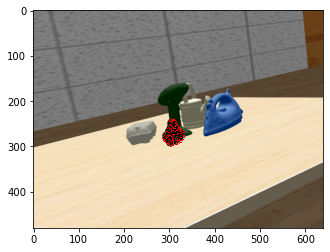

In [31]:
img = Image.open(os.path.join(input_dir,'rgb', "0000.png"))
ut.show_point_cloud_on_img(pixel_coord, img)